In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import os
import gc

from textblob import TextBlob
import gensim

from sklearn.model_selection import KFold

from keras.layers import *
from keras.initializers import *
from keras.constraints import *
from keras.regularizers import *
from keras.activations import *
from keras.optimizers import *
import keras.backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [3]:
TEXT_COL = 'comment_text'
EMB_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
MAXLEN = 220
MAX_FEATURES = 100000
EMBED_SIZE = 300
BATCH_SIZE = 2048
NUM_EPOCHS = 100

In [4]:
# https://www.kaggle.com/cpmpml/spell-checker-using-word2vec
# spell_model = gensim.models.KeyedVectors.load_word2vec_format('../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec')
# words = spell_model.index2word
# w_rank = {}

# for i,word in enumerate(words):
    # w_rank[word] = i
# WORDS = w_rank

# Use fast text as vocabulary
def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]])

In [5]:
def find(function, list):
    """ Returns the first item in the list for which function(item) is True, None otherwise.
    """
    for item in list:
        if function(item):
            return item

### MOOD ###########################################################################################
# Functions take Sentence objects, see pattern.text.tree.Sentence and pattern.text.parsetree().

INDICATIVE = "indicative"  # They went for a walk.
IMPERATIVE = "imperative"  # Let's go for a walk!
CONDITIONAL = "conditional" # It might be nice to go for a walk when it stops raining.
SUBJUNCTIVE = "subjunctive" # It would be nice to go for a walk sometime.


def s(word):
    return word.string.lower()


def join(words):
    return " ".join([w.string.lower() for w in words])


def question(sentence):
    return len(sentence) > 0 and sentence[-1].string == "?"


def verb(word):
    return word.type.startswith(("VB", "MD")) and (word.chunk is None or word.chunk.type.endswith("VP"))


def verbs(sentence, i=0, j=None):
    return [w for w in sentence[i:j or len(sentence)] if verb(w)]


def imperative(sentence, **kwargs):
    """ The imperative mood is used to give orders, commands, warnings, instructions, 
        or to make requests (if used with "please").
        It is marked by the infinitive form of the verb, without "to":
        "For goodness sake, just stop it!"
    """
    S = sentence
    if not (hasattr(S, "words") and hasattr(S, "parse_token")):
        raise TypeError("%s object is not a parsed Sentence" % repr(S.__class__.__name__))
    if question(S):
        return False
    if S.subjects and s(S.subjects[0]) not in ("you", "yourself"):
        # The subject can only identify as "you" (2sg): "Control yourself!".
        return False
    r = s(S).rstrip(" .!")
    for cc in ("if", "assuming", "provided that", "given that"):
        # A conjunction can also indicate conditional mood.
        if cc + " " in r:
            return False
    for i, w in enumerate(S):
        if verb(w):
            if s(w) in ("do", "let") and w == verbs(S)[0]:
                # "Do your homework!"
                return True
            if s(w) in ("do", "let"):
                # "Let's not argue."
                continue
            if s(w) in ("would", "should", "'d", "could", "can", "may", "might"):
                # "You should leave." => conditional.
                return False
            if s(w) in ("will", "shall") and i > 0 and s(S[i - 1]) == "you" and not verbs(S, 0, i):
                # "You will eat your dinner."
                continue
            if w.type == "VB" and (i == 0 or s(S[i - 1]) != "to"):
                # "Come here!"
                return True
            # Break on any other verb form.
            return False
    return False

#from __init__ import parse, Sentence
#
#for str in (
#  "Do your homework!",                   # True
#  "Do whatever you want.",               # True
#  "Do not listen to me.",                # True
#  "Do it if you think it is necessary.", # False
#  "Turn that off, will you.",            # True
#  "Let's help him.",                     # True
#  "Help me!",                            # True
#  "You will help me.",                   # True
#  "I hope you will help me.",            # False
#  "I can help you.",                     # False
#  "I can help you if you let me."):      # False
#    print str
#    print parse(str)
#    print imperative(Sentence(parse(str)))
#    print


def conditional(sentence, predictive=True, **kwargs):
    """ The conditional mood is used to talk about possible or imaginary situations.
        It is marked by the infinitive form of the verb, preceded by would/could/should:
        "we should be going", "we could have stayed longer".
        With predictive=False, sentences with will/shall need an explicit if/when/once-clause:
        - "I will help you" => predictive.
        - "I will help you if you pay me" => speculative.
        Sentences with can/may always need an explicit if-clause.
    """
    S = sentence
    if not (hasattr(S, "words") and hasattr(S, "parse_token")):
        raise TypeError("%s object is not a parsed Sentence" % repr(S.__class__.__name__))
    if question(S):
        return False
    i = find(lambda w: s(w) == "were", S)
    i = i and i.index or 0
    if i > 0 and (s(S[i - 1]) in ("i", "it", "he", "she") or S[i - 1].type == "NN"):
        # "As if it were summer already." => subjunctive (wish).
        return False
    for i, w in enumerate(S):
        if w.type == "MD":
            if s(w) == "ought" and i < len(S) and s(S[i + 1]) == "to":
                # "I ought to help you."
                return True
            if s(w) in ("would", "should", "'d", "could", "might"):
                # "I could help you."
                return True
            if s(w) in ("will", "shall", "'ll") and i > 0 and s(S[i - 1]) == "you" and not verbs(S, 0, i):
                # "You will help me." => imperative.
                return False
            if s(w) in ("will", "shall", "'ll") and predictive:
                # "I will help you." => predictive.
                return True
            if s(w) in ("will", "shall", "'ll", "can", "may"):
                # "I will help you when I get back." => speculative.
                r = s(S).rstrip(" .!")
                for cc in ("if", "when", "once", "as soon as", "assuming", "provided that", "given that"):
                    if cc + " " in r:
                        return True
    return False

#from __init__ import parse, Sentence
#
#for str in (
#  "We ought to help him.",          # True
#  "We could help him.",             # True
#  "I will help you.",               # True
#  "You will help me.",              # False (imperative)
#  "I hope you will help me.",       # True (predictive)
#  "I can help you.",                # False
#  "I can help you if you let me."): # True
#    print str
#    print parse(str)
#    print conditional(Sentence(parse(str)))
#    print

subjunctive1 = [
    "advise", "ask", "command", "demand", "desire", "insist",
    "propose", "recommend", "request", "suggest", "urge"]
subjunctive2 = [
    "best", "crucial", "desirable", "essential", "imperative",
    "important", "recommended", "urgent", "vital"]

for w in list(subjunctive1): # Inflect.
    subjunctive1.append(w + "s")
    subjunctive1.append(w.rstrip("e") + "ed")


def subjunctive(sentence, classical=True, **kwargs):
    """ The subjunctive mood is a classical mood used to express a wish, judgment or opinion.
        It is marked by the verb wish/were, or infinitive form of a verb
        preceded by an "it is"-statement:
        "It is recommended that he bring his own computer."
    """
    S = sentence
    if not (hasattr(S, "words") and hasattr(S, "parse_token")):
        raise TypeError("%s object is not a parsed Sentence" % repr(S.__class__.__name__))
    if question(S):
        return False
    for i, w in enumerate(S):
        b = False
        if w.type.startswith("VB"):
            if s(w).startswith("wish"):
                # "I wish I knew."
                return True
            if s(w) == "hope" and i > 0 and s(S[i - 1]) in ("i", "we"):
                # "I hope ..."
                return True
            if s(w) == "were" and i > 0 and (s(S[i - 1]) in ("i", "it", "he", "she") or S[i - 1].type == "NN"):
                # "It is as though she were here." => counterfactual.
                return True
            if s(w) in subjunctive1:
                # "I propose that you be on time."
                b = True
            elif s(w) == "is" and 0 < i < len(S) - 1 and s(S[i - 1]) == "it" \
             and s(S[i + 1]) in subjunctive2:
                # "It is important that you be there." => but you aren't (yet).
                b = True
            elif s(w) == "is" and 0 < i < len(S) - 3 and s(S[i - 1]) == "it" \
             and s(S[i + 2]) in ("good", "bad") and s(S[i + 3]) == "idea":
                # "It is a good idea that you be there."
                b = True
        if b:
            # With classical=False, "It is important that you are there." passes.
            # This is actually an informal error: it states a fact, not a wish.
            v = find(lambda w: w.type.startswith("VB"), S[i + 1:])
            if v and classical is True and v and v.type == "VB":
                return True
            if v and classical is False:
                return True
    return False

#from __init__ import parse, Sentence
#
#for str in (
#  "I wouldn't do that if I were you.", # True
#  "I wish I knew.",                    # True
#  "I propose that you be on time.",    # True
#  "It is a bad idea to be late.",      # True
#  "I will be dead."):                  # False, predictive
#    print str
#    print parse(str)
#    print subjunctive(Sentence(parse(str)))
#    print


def negated(sentence, negative=("not", "n't", "never")):
    if hasattr(sentence, "string"):
        # Sentence object => string.
        sentence = sentence.string
    S = " %s " % (sentence).strip(".?!").lower()
    for w in negative:
        if " %s " % w in S:
            return True
    return False


def mood(sentence, **kwargs):
    """ Returns IMPERATIVE (command), CONDITIONAL (possibility), SUBJUNCTIVE (wish) or INDICATIVE (fact).
    """
    if isinstance(sentence, str):
        try:
            # A Sentence is expected but a string given.
            # Attempt to parse the string on-the-fly.
            from pattern.en import parse, Sentence
            sentence = Sentence(parse(sentence))
        except ImportError:
            pass
    if imperative(sentence, **kwargs):
        return IMPERATIVE
    if conditional(sentence, **kwargs):
        return CONDITIONAL
    if subjunctive(sentence, **kwargs):
        return SUBJUNCTIVE
    else:
        return INDICATIVE

### MODALITY #######################################################################################
# Functions take Sentence objects, see pattern.text.tree.Sentence and pattern.text.parsetree().


def d(*args):
    return dict.fromkeys(args, True)

AUXILLARY = {
      "be": ["be", "am", "m", "are", "is", "being", "was", "were" "been"],
     "can": ["can", "ca", "could"],
    "dare": ["dare", "dares", "daring", "dared"],
      "do": ["do", "does", "doing", "did", "done"],
    "have": ["have", "ve", "has", "having", "had"],
     "may": ["may", "might"],
    "must": ["must"],
    "need": ["need", "needs", "needing", "needed"],
   "ought": ["ought"],
   "shall": ["shall", "sha"],
    "will": ["will", "ll", "wo", "willing", "would", "d"]
}

MODIFIERS = ("fully", "highly", "most", "much", "strongly", "very")

EPISTEMIC = "epistemic" # Expresses degree of possiblity.

# -1.00 = NEGATIVE
# -0.75 = NEGATIVE, with slight doubts
# -0.50 = NEGATIVE, with doubts
# -0.25 = NEUTRAL, slightly negative
# +0.00 = NEUTRAL
# +0.25 = NEUTRAL, slightly positive
# +0.50 = POSITIVE, with doubts
# +0.75 = POSITIVE, with slight doubts
# +1.00 = POSITIVE

epistemic_MD = { # would => could => can => should => shall => will => must
    -1.00: d(),
    -0.75: d(),
    -0.50: d("would"),
    -0.25: d("could", "dare", "might"),
     0.00: d("can", "ca", "may"),
    +0.25: d("ought", "should"),
    +0.50: d("shall", "sha"),
    +0.75: d("will", "'ll", "wo"),
    +1.00: d("have", "has", "must", "need"),
}

epistemic_VB = { # wish => feel => believe => seem => think => know => prove + THAT
    -1.00: d(),
    -0.75: d(),
    -0.50: d("dispute", "disputed", "doubt", "question"),
    -0.25: d("hope", "want", "wish"),
     0.00: d("guess", "imagine", "seek"),
    +0.25: d("appear", "bet", "feel", "hear", "rumor", "rumour", "say", "said", "seem", "seemed",
             "sense", "speculate", "suspect", "suppose", "wager"),
    +0.50: d("allude", "anticipate", "assume", "claim", "claimed", "believe", "believed",
             "conjecture", "consider", "considered", "decide", "expect", "find", "found",
             "hypothesize", "imply", "indicate", "infer", "postulate", "predict", "presume",
             "propose", "report", "reported", "suggest", "suggested", "tend",
             "think", "thought"),
    +0.75: d("know", "known", "look", "see", "show", "shown"),
    +1.00: d("certify", "demonstrate", "prove", "proven", "verify"),
}

epistemic_RB = { # unlikely => supposedly => maybe => probably => usually => clearly => definitely
    -1.00: d("impossibly"),
    -0.75: d("hardly"),
    -0.50: d("presumptively", "rarely", "scarcely", "seldomly", "uncertainly", "unlikely"),
    -0.25: d("almost", "allegedly", "debatably", "nearly", "presumably", "purportedly", "reportedly",
             "reputedly", "rumoredly", "rumouredly", "supposedly"),
     0.00: d("barely", "hypothetically", "maybe", "occasionally", "perhaps", "possibly", "putatively",
             "sometimes", "sporadically", "traditionally", "widely"),
    +0.25: d("admittedly", "apparently", "arguably", "believably", "conceivably", "feasibly", "fairly",
             "hopefully", "likely", "ostensibly", "potentially", "probably", "quite", "seemingly"),
    +0.50: d("commonly", "credibly", "defendably", "defensibly", "effectively", "frequently",
             "generally", "largely", "mostly", "normally", "noticeably", "often", "plausibly",
             "reasonably", "regularly", "relatively", "typically", "usually"),
    +0.75: d("assuredly", "certainly", "clearly", "doubtless", "evidently", "evitably", "manifestly",
             "necessarily", "nevertheless", "observably", "ostensively", "patently", "plainly",
             "positively", "really", "surely", "truly", "undoubtably", "undoubtedly", "verifiably"),
    +1.00: d("absolutely", "always", "definitely", "incontestably", "indisputably", "indubitably",
             "ineluctably", "inescapably", "inevitably", "invariably", "obviously", "unarguably",
             "unavoidably", "undeniably", "unquestionably")
}

epistemic_JJ = {
    -1.00: d("absurd", "prepostoreous", "ridiculous"),
    -0.75: d("inconceivable", "unthinkable"),
    -0.50: d("misleading", "scant", "unlikely", "unreliable"),
    -0.25: d("customer-centric", "doubtful", "ever", "ill-defined, ""inadequate", "late",
             "uncertain", "unclear", "unrealistic", "unspecified", "unsure", "wild"),
     0.00: d("dynamic", "possible", "unknown"),
    +0.25: d("according", "creative", "likely", "local", "innovative", "interesting",
             "potential", "probable", "several", "some", "talented", "viable"),
    +0.50: d("certain", "generally", "many", "notable", "numerous", "performance-oriented",
             "promising", "putative", "well-known"),
    +0.75: d("concrete", "credible", "famous", "important", "major", "necessary", "original",
             "positive", "significant", "real", "robust", "substantial", "sure"),
    +1.00: d("confirmed", "definite", "prime", "undisputable"),
}

epistemic_NN = {
    -1.00: d("fantasy", "fiction", "lie", "myth", "nonsense"),
    -0.75: d("controversy"),
    -0.50: d("criticism", "debate", "doubt"),
    -0.25: d("belief", "chance", "faith", "luck", "perception", "speculation"),
     0.00: d("challenge", "guess", "feeling", "hunch", "opinion", "possibility", "question"),
    +0.25: d("assumption", "expectation", "hypothesis", "notion", "others", "team"),
    +0.50: d("example", "proces", "theory"),
    +0.75: d("conclusion", "data", "evidence", "majority", "proof", "symptom", "symptoms"),
    +1.00: d("fact", "truth", "power"),
}

epistemic_CC_DT_IN = {
     0.00: d("either", "whether"),
    +0.25: d("however", "some"),
    +1.00: d("despite")
}

epistemic_PRP = {
    +0.25: d("I", "my"),
    +0.50: d("our"),
    +0.75: d("we")
}

epistemic_weaseling = {
    -0.75: d("popular belief"),
    -0.50: d("but that", "but this", "have sought", "might have", "seems to"),
    -0.25: d("may also", "may be", "may have", "may have been", "some have", "sort of"),
    +0.00: d("been argued", "believed to", "considered to", "claimed to", "is considered", "is possible",
             "overall solutions", "regarded as", "said to"),
    +0.25: d("a number of", "in some", "one of", "some of",
             "many modern", "many people", "most people", "some people", "some cases", "some studies",
             "scientists", "researchers"),
    +0.50: d("in several", "is likely", "many of", "many other", "of many", "of the most", "such as",
             "several reasons", "several studies", "several universities", "wide range"),
    +0.75: d("almost always", "and many", "and some", "around the world", "by many", "in many", "in order to",
             "most likely"),
    +1.00: d("i.e.", "'s most", "of course", "There are", "without doubt"),
}


def modality(sentence, type=EPISTEMIC):
    """ Returns the sentence's modality as a weight between -1.0 and +1.0.
        Currently, the only type implemented is EPISTEMIC.
        Epistemic modality is used to express possibility (i.e. how truthful is what is being said).
    """
    if isinstance(sentence, str):
        try:
            # A Sentence is expected but a string given.
            # Attempt to parse the string on-the-fly.
            from pattern.en import parse, Sentence
            sentence = Sentence(parse(sentence))
        except ImportError:
            pass
    S, n, m = sentence, 0.0, 0
    if not (hasattr(S, "words") and hasattr(S, "parse_token")):
        raise TypeError("%s object is not a parsed Sentence" % repr(S.__class__.__name__))
    if type == EPISTEMIC:
        r = S.string.rstrip(" .!")
        for k, v in epistemic_weaseling.items():
            for phrase in v:
                if phrase in r:
                    n += k
                    m += 2
        for i, w in enumerate(S.words):
            for type, dict, weight in (
              (  "MD", epistemic_MD, 4),
              (  "VB", epistemic_VB, 2),
              (  "RB", epistemic_RB, 2),
              (  "JJ", epistemic_JJ, 1),
              (  "NN", epistemic_NN, 1),
              (  "CC", epistemic_CC_DT_IN, 1),
              (  "DT", epistemic_CC_DT_IN, 1),
              (  "IN", epistemic_CC_DT_IN, 1),
              ("PRP" , epistemic_PRP, 1),
              ("PRP$", epistemic_PRP, 1),
              ( "WP" , epistemic_PRP, 1)):
                # "likely" => weight 1, "very likely" => weight 2
                if i > 0 and s(S[i - 1]) in MODIFIERS:
                    weight += 1
                # likely" => score 0.25 (neutral inclining towards positive).
                if w.type and w.type.startswith(type):
                    for k, v in dict.items():
                        # Prefer lemmata.
                        if (w.lemma or s(w)) in v:
                            # Reverse score for negated terms.
                            if i > 0 and s(S[i - 1]) in ("not", "n't", "never", "without"):
                                k = -k * 0.5
                            n += weight * k
                            m += weight
                            break
            # Numbers, citations, explanations make the sentence more factual.
            if w.type in ("CD", "\"", "'", ":", "("):
                n += 0.75
                m += 1
    if m == 0:
        return 1.0 # No modal verbs/adverbs used, so statement must be true.
    return max(-1.0, min(n / (m or 1), +1.0))


def uncertain(sentence, threshold=0.5):
    return modality(sentence) <= threshold

In [6]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir=EMB_PATH):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

def build_embedding_matrix(word_index, embeddings_index, MAX_FEATURES, lower = True, verbose = True):
    embedding_matrix = np.zeros((MAX_FEATURES, EMBED_SIZE))
    for word, i in tqdm(word_index.items(),disable = not verbose):
        if lower:
            word = word.lower()
        if i >= MAX_FEATURES: continue
        try:
            embedding_vector = embeddings_index[word]
        except:
            embedding_vector = embeddings_index["unknown"]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [7]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)
tokenizer.fit_on_texts(list(train_df[TEXT_COL]) + list(test_df[TEXT_COL]))
word_index = tokenizer.word_index

# keys = list(word_index.keys())
# for key in keys:
    # correct_key = correction(key)
    # if correct_key != key and correct_key in keys:
        # word_index[key] = word_index[correct_key]

X_train = tokenizer.texts_to_sequences(list(train_df[TEXT_COL]))
X_test = tokenizer.texts_to_sequences(list(test_df[TEXT_COL]))

X_train = pad_sequences(X_train, maxlen=MAXLEN)
X_test = pad_sequences(X_test, maxlen=MAXLEN)

y_train = train_df['target'].values

del tokenizer
gc.collect()

0

In [8]:
embeddings_index = load_embeddings()
embedding_matrix = build_matrix(word_index, embeddings_index)
del embeddings_index
gc.collect()

2000001it [03:12, 10391.18it/s]


0

In [9]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [10]:
# https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/attlayer.py
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [11]:
class Capsule(Layer):
    """Capsule Layer implementation in Keras
       This implementation is based on Dynamic Routing of Capsules,
       Geoffrey Hinton et. al.
       The Capsule Layer is a Neural Network Layer which helps
       modeling relationships in image and sequential data better
       than just CNNs or RNNs. It achieves this by understanding
       the spatial relationships between objects (in images)
       or words (in text) by encoding additional information
       about the image or text, such as angle of rotation,
       thickness and brightness, relative proportions etc.
       This layer can be used instead of pooling layers to
       lower dimensions and still capture important information
       about the relationships and structures within the data.
       A normal pooling layer would lose a lot of
       this information.
       This layer can be used on the output of any layer
       which has a 3-D output (including batch_size). For example,
       in image classification, it can be used on the output of a
       Conv2D layer for Computer Vision applications. Also,
       it can be used on the output of a GRU or LSTM Layer
       (Bidirectional or Unidirectional) for NLP applications.
       The default activation function is 'linear'. But, this layer
       is generally used with the 'squash' activation function
       (recommended). To use the squash activation function, do :
       from keras_contrib.activations import squash
       capsule = Capsule(num_capsule=10,
                         dim_capsule=10,
                         routings=3,
                         share_weights=True,
                         activation=squash)
       # Example usage :
           1). COMPUTER VISION
           input_image = Input(shape=(None, None, 3))
           conv_2d = Conv2D(64,
                            (3, 3),
                            activation='relu')(input_image)
           capsule = Capsule(num_capsule=10,
                             dim_capsule=16,
                             routings=3,
                             activation='relu',
                             share_weights=True)(conv_2d)
           2). NLP
           maxlen = 72
           max_features = 120000
           input_text = Input(shape=(maxlen,))
           embedding = Embedding(max_features,
                                 embed_size,
                                 weights=[embedding_matrix],
                                 trainable=False)(input_text)
           bi_gru = Bidirectional(GRU(64,
                                      return_seqeunces=True))(embedding)
           capsule = Capsule(num_capsule=5,
                             dim_capsule=5,
                             routings=4,
                             activation='sigmoid',
                             share_weights=True)(bi_gru)
       # Arguments
           num_capsule : Number of Capsules (int)
           dim_capsules : Dimensions of the vector output of each Capsule (int)
           routings : Number of dynamic routings in the Capsule Layer (int)
           share_weights : Whether to share weights between Capsules or not
           (boolean)
           activation : Activation function for the Capsules
           regularizer : Regularizer for the weights of the Capsules
           initializer : Initializer for the weights of the Caspules
           constraint : Constraint for the weights of the Capsules
       # Input shape
            3D tensor with shape:
            (batch_size, input_num_capsule, input_dim_capsule)
            [any 3-D Tensor with the first dimension as batch_size]
       # Output shape
            3D tensor with shape:
            (batch_size, num_capsule, dim_capsule)
       # References
        - [Dynamic-Routing-Between-Capsules]
          (https://arxiv.org/pdf/1710.09829.pdf)
        - [Keras-Examples-CIFAR10-CNN-Capsule]"""

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 initializer='glorot_uniform',
                 activation=None,
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights

        self.activation = activations.get(activation)
        self.regularizer = regularizers.get(regularizer)
        self.initializer = initializers.get(initializer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)

        self.build = True

    def call(self, inputs):
        if self.share_weights:
            u_hat_vectors = K.conv1d(inputs, self.W)
        else:
            u_hat_vectors = K.local_conv1d(inputs, self.W, [1], [1])

        # u_hat_vectors : The spatially transformed input vectors (with local_conv_1d)

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        u_hat_vectors = K.reshape(u_hat_vectors, (batch_size,
                                                  input_num_capsule,
                                                  self.num_capsule,
                                                  self.dim_capsule))

        u_hat_vectors = K.permute_dimensions(u_hat_vectors, (0, 2, 1, 3))
        routing_weights = K.zeros_like(u_hat_vectors[:, :, :, 0])

        for i in range(self.routings):
            capsule_weights = K.softmax(routing_weights, 1)
            outputs = K.batch_dot(capsule_weights, u_hat_vectors, [2, 2])
            if K.ndim(outputs) == 4:
                outputs = K.sum(outputs, axis=1)
            if i < self.routings - 1:
                outputs = K.l2_normalize(outputs, -1)
                routing_weights = K.batch_dot(outputs, u_hat_vectors, [2, 3])
                if K.ndim(routing_weights) == 4:
                    routing_weights = K.sum(routing_weights, axis=1)

        return self.activation(outputs)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = {'num_capsule': self.num_capsule,
                  'dim_capsule': self.dim_capsule,
                  'routings': self.routings,
                  'share_weights': self.share_weights,
                  'activation': activations.serialize(self.activation),
                  'regularizer': regularizers.serialize(self.regularizer),
                  'initializer': initializers.serialize(self.initializer),
                  'constraint': constraints.serialize(self.constraint)}

        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [12]:
def squash(x, axis=-1):
    """
    Squash activation function (generally used in Capsule layers).
    """
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

In [13]:
def get_model():
    inp = Input(shape=(MAXLEN,))
    embed_inp = Embedding(len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=MAXLEN, trainable=False)(inp)
    embed_inp = SpatialDropout1D(0.2)(embed_inp)
    
    bi_lstm = Bidirectional(CuDNNLSTM(64, return_sequences=True))(embed_inp)
    # bi_gru = Bidirectional(CuDNNGRU(96, return_sequences=True))(bi_lstm)
    
    max_pool = GlobalMaxPooling1D()(bi_lstm)
    avg_pool = GlobalAveragePooling1D()(bi_lstm)
    attention = AttentionWeightedAverage()(bi_lstm)
    # capsule = Capsule(num_capsule=10, dim_capsule=10, routings=4, activation=squash)(bi_gru)
    # capsule = Flatten()(capsule)
    
    x = concatenate([max_pool, avg_pool, attention], axis=1)
    # x = Dropout(rate=0.1)(x)
    # x = Dense(16)(x)
    outp = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, outp)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005, decay=0.001), metrics=['acc'])
    
    return model

In [14]:
sample_model  = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
sample_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 220, 300)     123014100   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 220, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 220, 128)     187392      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_max

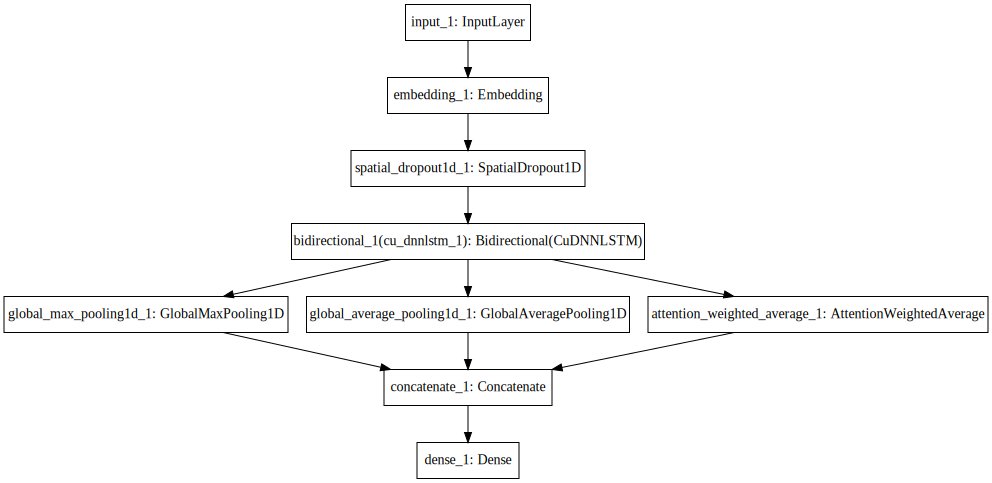

In [16]:
SVG(model_to_dot(sample_model).create(prog='dot', format='svg'))

In [17]:
splits = list(KFold(n_splits=5).split(X_train,y_train))

oof_preds = np.zeros((X_train.shape[0]))
test_preds = np.zeros((X_test.shape[0]))

for fold in [0, 1, 2, 3, 4]:
    K.clear_session()
    tr_ind, val_ind = splits[fold]

    ckpt = ModelCheckpoint(f'gru_{fold}.hdf5', save_best_only = True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    model = get_model()

    model.fit(X_train[tr_ind],
              y_train[tr_ind]>0.5,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(X_train[val_ind], y_train[val_ind]>0.5),
              callbacks = [es,ckpt])

    oof_preds[val_ind] += model.predict(X_train[val_ind])[:,0]
    test_preds += model.predict(X_test)[:,0]

test_preds /= 5

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/100
1443899/1443899 [==============================] - 142s 98us/step - loss: 0.1193 - acc: 0.9568 - val_loss: 0.0923 - val_acc: 0.9648
Epoch 2/100
1443899/1443899 [==============================] - 139s 96us/step - loss: 0.0939 - acc: 0.9642 - val_loss: 0.0893 - val_acc: 0.9658
Epoch 3/100
1443899/1443899 [==============================] - 139s 96us/step - loss: 0.0897 - acc: 0.9656 - val_loss: 0.0886 - val_acc: 0.9657
Epoch 4/100
1443899/1443899 [==============================] - 139s 96us/step - loss: 0.0873 - acc: 0.9664 - val_loss: 0.0893 - val_acc: 0.9650
Epoch 5/100
1443899/1443899 [==============================] - 139s 96us/step - loss: 0.0854 - acc: 0.9670 - val_loss: 0.0863 - val_acc: 0.9669
Epoch 6/100
1443899/1443899 [==============================] - 139s 97us/step - loss: 0.0838 - acc: 0

In [18]:
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv', index_col='id')
submission['prediction'] = test_preds
submission.reset_index(drop=False, inplace=True)
submission.head()

,id,prediction
0,7000000,0.000426
1,7000001,0.000039
2,7000002,0.003385
3,7000003,0.000786
4,7000004,0.957688


In [19]:
submission.to_csv('submission.csv', index=False)